# Extracción, transformación y Carga de datos a la nube
Con este codigo se extraen los datos y se cargan a la integración REST API dentro de Datagran, habilitandolos para hacer analitica

In [1]:
!pip install matplotlib
!pip install seaborn
!pip install openpyxl
!pip install holidays_co

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 153.6/153.6 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 20.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 310.7/310.7 kB 28.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 43.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 51.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 54.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.1/103.1 kB 6.1 MB/s eta 0:00:00
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.2/61.2 kB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.6/294.6 kB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, date
from upload_file import upload_file
from ide_utils.input_tables import load_dask
from ide_utils.output_table import send_to_output_table
import holidays_co
from sklearn.preprocessing import LabelEncoder
import statistics

# Definicion de funciones necesarias para la transformación de los datos

def load_data(Link, header):
  data = pd.read_excel(Link, header=header)
  data_columns = data.columns
  data.fillna(0, inplace=True)
  # Convirtiendo los nombres de las columnas en string
  data_columns = list(map(lambda index: str(index).replace(':00:00', ''), data_columns))

  # Asignando el verdadero valor de las columnas 0 y 1
  data_columns[0] = 'Fecha'
  data_columns[1] = 'Linea'
  data = data.set_axis(data_columns, axis=1).drop(data.columns[-1], axis=1)

  # Convirtiendo las horas en columnas como observaciones del DF
  data = data.set_index(['Fecha', 'Linea']).stack()
  data = data.reset_index().rename(columns={'level_2': 'Horas', 0: 'Qty_passangers'})

  # Organizando la columna de Lineas
  data['Linea'] = data.Linea.apply(lambda x: x.replace("LÍNEA ", ""))
  return data

def convert_to_date_format(day_of_year, year):
  date_convert = datetime.fromordinal(date(2021, 1, 1).toordinal() + day_of_year)
  return date_convert.strftime("%Y-%m-%d")

# Modelos para la transformación de los datos
le = LabelEncoder()

In [4]:
afluencia_2021 = load_data("https://www.arcgis.com/sharing/rest/content/items/90bda39bd6d848de8c7eebd2b66d801e/data", header=2)
afluencia_2022 = load_data("https://www.arcgis.com/sharing/rest/content/items/1450e500041842a387444633ac656798/data", header=1)
afluencia_2023 = load_data("https://www.arcgis.com/sharing/rest/content/items/19f40fa21e204565a14482bee823ec44/data", header=1)
# Uniendo todos los datasets
all_data = pd.concat([afluencia_2021, afluencia_2022, afluencia_2023])
all_data.head()

,Fecha,Linea,Horas,Qty_passangers
0,44197,A,04,0.0
1,44197,A,05,3487.0
2,44197,A,06,3405.0
3,44197,A,07,2011.0
4,44197,A,08,1148.0


El valor de la fecha que se observa en el head es un valor mal formateado que viene desde el archivo. Es necesario arreglarlo.

Para abordar este problema de formateo, primero conozcamos la naturaleza de la columna que tenemos actualmente. Es posible utilizar la información actual para recuperar la información original?


El vector de días tiene 365 posiciones, además de ser ascendente (Como se puede observar en la siguiente imagen)



Text(0, 0.5, 'Valor en la columna Fecha')

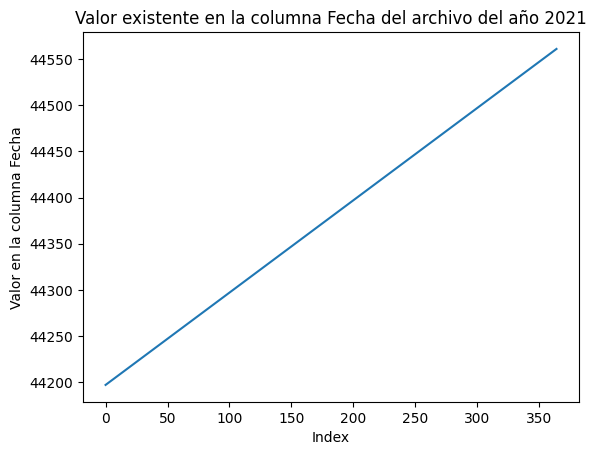

In [5]:
dias = afluencia_2021.Fecha.unique()
texto = f"""
El vector de días tiene {len(dias)} posiciones, además de ser ascendente (Como se puede observar en la siguiente imagen)
"""
print(texto)
plt.plot(dias)
plt.title('Valor existente en la columna Fecha del archivo del año 2021')
plt.xlabel('Index')
plt.ylabel('Valor en la columna Fecha')

Se puede aprovechar esta ascendencia del vector existente en la columna fecha. Ya que es posible codificar cada valor entre 0 y 364, y de esta manera se tendría cada uno de los días del año 2021 en formato %. Solucionando así el problema de formato

In [6]:
# Arreglando la columna Fecha del año 2021
afluencia_2021['Fecha'] = le.fit_transform(afluencia_2021['Fecha'])
afluencia_2021['Fecha'] = afluencia_2021.Fecha.apply(lambda x: convert_to_date_format(x, 2021))
all_data = pd.concat([afluencia_2021, afluencia_2022, afluencia_2023])
all_data['Fecha'] = pd.to_datetime(all_data['Fecha'], format='%Y-%m-%d')
all_data['uploaded'] = datetime.now()
all_data.head()

,Fecha,Linea,Horas,Qty_passangers,uploaded
0,2021-01-01,A,04,0.0,2023-11-13 19:49:06.179440
1,2021-01-01,A,05,3487.0,2023-11-13 19:49:06.179440
2,2021-01-01,A,06,3405.0,2023-11-13 19:49:06.179440
3,2021-01-01,A,07,2011.0,2023-11-13 19:49:06.179440
4,2021-01-01,A,08,1148.0,2023-11-13 19:49:06.179440


Tambien es importante enriquecer la data lo mas posible. Por esto se agrega información sobre festividades.

In [7]:
# Agregando los festivos al dataset

festivos = []
for anio in all_data.Fecha.dt.year.unique():
  festivos = festivos + list(map(lambda x: str(x.date), holidays_co.get_colombia_holidays_by_year(anio)))

all_data['festivos'] = all_data.Fecha.astype(str).apply(lambda x: 1 if x in festivos else 0)


El formato de la columna aparentemente quedó bien. Confirmemos

Tiene consistencia temporal en el año?

In [8]:
afluencia_2021.loc[(afluencia_2021.Linea=='A') & (afluencia_2021.Horas=='12')]

,Fecha,Linea,Horas,Qty_passangers
8,2021-01-01,A,12,1201.0
208,2021-01-02,A,12,4321.0
408,2021-01-03,A,12,9866.0
628,2021-01-04,A,12,16145.0
828,2021-01-05,A,12,15835.0
...,...,...,...,...
81248,2021-12-27,A,12,23868.0
81488,2021-12-28,A,12,24112.0
81728,2021-12-29,A,12,23813.0
81968,2021-12-30,A,12,25058.0


La columna quedó arreglada

## Integridad temporal de las lineas

Cantidad de días por linea que se tienen en cada uno de los años existentes en el dataset:

In [9]:
integridad_temporal_df = pd.DataFrame(afluencia_2021.loc[afluencia_2021.Horas=='12', 'Linea'].value_counts()).rename(columns={'Linea': 2021})
integridad_temporal_df['2022'] = afluencia_2022.loc[afluencia_2022.Horas=='12', 'Linea'].value_counts()
integridad_temporal_df['2023'] = afluencia_2023.loc[afluencia_2023.Horas=='12', 'Linea'].value_counts()
integridad_temporal_df

,2021,2022,2023
A,365,365,181
B,365,365,181
1,365,365,181
T-A,365,365,181
O,365,365,181
M,363,362,181
2,362,365,181
H,362,357,181
J,359,357,181
K,354,354,181


Es recomendable completar la ventana temporal para cada linea. De esta manera, cada linea tendrá un espacio para registros para cada día. De esta manera se puede abordar con mayor facilidad el como rellenar estos espacios vacios.

Para hacer esto, se puede aprovechar la integridad temporal de la Linea A, ya que, en la grafica anterior se puede ver que tiene datos en todos los días de la ventana temporal seleccionada y realizar un left join, dejando espacios vacios en los lugares donde no haga match, y por ende falten datos.

In [10]:
rango_fechas = pd.DataFrame(all_data.loc[(all_data.Linea=='A'), ['Fecha', 'Horas']].reset_index(drop=True))

for linea in all_data.Linea.unique():
  rango_fechas[linea] = linea

rango_fechas = rango_fechas.set_index(['Fecha', 'Horas']).stack()
rango_fechas = pd.DataFrame(rango_fechas).reset_index().drop(0, axis=1).rename(columns={'level_2': 'Linea'})

# Usando la ventana temporal completa, se agregan los valores en cada hora
df = rango_fechas.merge(all_data, on=['Fecha', 'Horas', 'Linea'], how='left')
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 218640 entries, 0 to 218639
Data columns (total 6 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   Fecha           218640 non-null  datetime64[ns]
 1   Horas           218640 non-null  object        
 2   Linea           218640 non-null  object        
 3   Qty_passangers  211280 non-null  float64       
 4   uploaded        211280 non-null  datetime64[ns]
 5   festivos        211280 non-null  float64       
dtypes: datetime64[ns](2), float64(2), object(2)
memory usage: 11.7+ MB


Debido a que hay mas de 2 dimensiones en los datos no es posible visualizar la matriz completa. Sin embargo, es posible sacar una foto de cada día del año, y esperar que el comportamiento de la existencia de los datos se mantenga. Esto es:

- Si una hora del día X tiene datos, podemos esperar que todas las horas de este día X tengan datos.

De esta manera, veamos el comportamiento a lo largo de la ventana de tiempo


[Text(0.5, 1.0, 'Vacios del data set a medio día')]

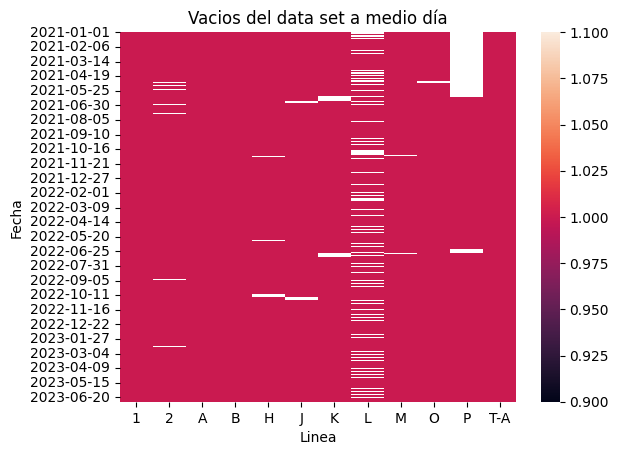

In [10]:
data_chart = all_data.loc[(all_data.Horas=='12')].copy()
data_chart['Fecha'] = data_chart.Fecha.astype(str)
data_chart['Qty_passangers'] = data_chart.Qty_passangers.apply(lambda x: 1 if x else 0)
data_chart = data_chart.pivot("Fecha", "Linea", "Qty_passangers")

sns.heatmap(data_chart).set(title='Vacios del data set a medio día')

Vacios del set a horas extremo: 04 y 23

[Text(0.5, 1.0, 'Vacios del data set a medio día')]

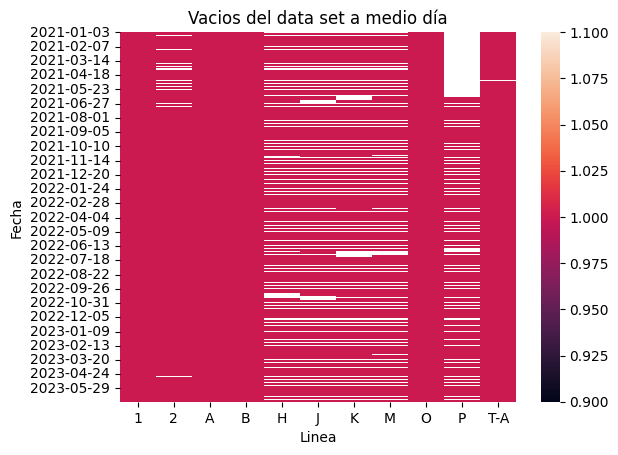

In [11]:
data_chart = all_data.loc[(all_data.Horas=='04')].copy()
data_chart['Fecha'] = data_chart.Fecha.astype(str)
data_chart['Qty_passangers'] = data_chart.Qty_passangers.apply(lambda x: 1 if x else 0)
data_chart = data_chart.pivot("Fecha", "Linea", "Qty_passangers")

sns.heatmap(data_chart).set(title='Vacios del data set a medio día')

[Text(0.5, 1.0, 'Vacios del data set a medio día')]

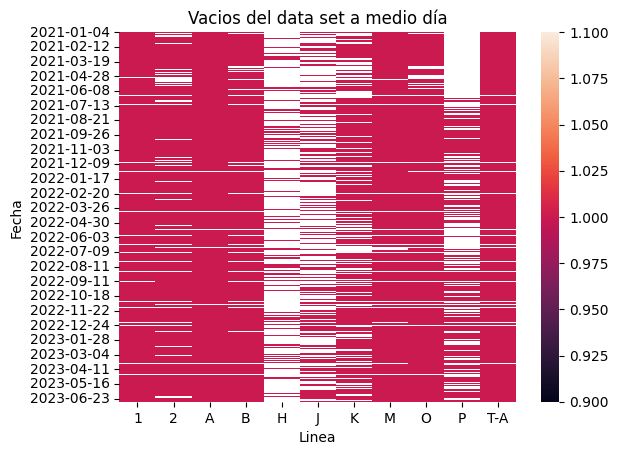

In [12]:
data_chart = all_data.loc[(all_data.Horas=='23')].copy()
data_chart['Fecha'] = data_chart.Fecha.astype(str)
data_chart['Qty_passangers'] = data_chart.Qty_passangers.apply(lambda x: 1 if x else 0)
data_chart = data_chart.pivot("Fecha", "Linea", "Qty_passangers")

sns.heatmap(data_chart).set(title='Vacios del data set a medio día')

Basado en lo observado en las graficas anteriores, podemos decir que las horas extremo pueden eliminarse, ya que su contenido de 0's es demasiado alto. Tambien se observa que la linea P no tiene el espacio temporal completo, faltandole aproximadamente 5 meses, por lo que podría eliminarse esta linea tambien.

La Linea L, por otro lado tiene una enorme cantidad de vacios tambien, por lo que se excluirá por el momento

## Eliminando horas extremo y lineas con muchos vacios

In [11]:
# Eliminando horas extremo
all_data = all_data.loc[~all_data.Horas.isin(['04', '23'])]
all_data = all_data.loc[~all_data.Linea.isin(['P', 'L'])]

[Text(0.5, 1.0, 'Vacios en 2021')]

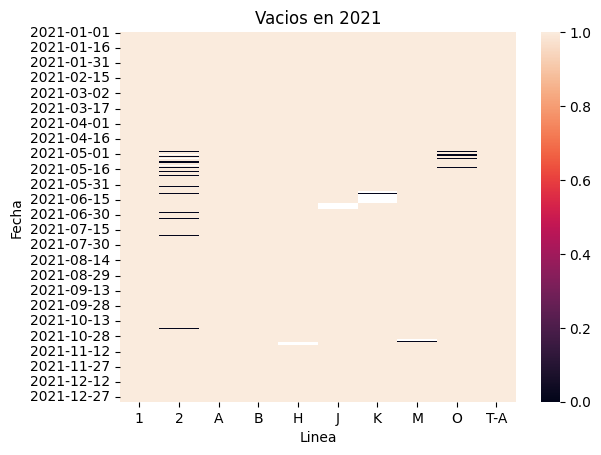

In [13]:
data_chart = all_data.loc[(all_data.Horas=='12') & (all_data.Fecha.dt.year==2021)].copy()
data_chart['Fecha'] = data_chart.Fecha.astype(str)
data_chart['Qty_passangers'] = data_chart.Qty_passangers.apply(lambda x: 1 if x else 0)
data_chart = data_chart.pivot("Fecha", "Linea", "Qty_passangers")

sns.heatmap(data_chart).set(title='Vacios en 2021')

[Text(0.5, 1.0, 'Vacios en 2022')]

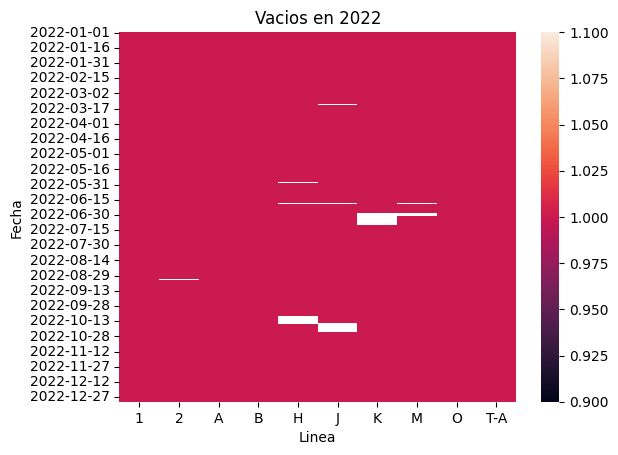

In [15]:
data_chart = all_data.loc[(all_data.Horas=='12') & (all_data.Fecha.dt.year==2022)].copy()
data_chart['Fecha'] = data_chart.Fecha.astype(str)
data_chart['Qty_passangers'] = data_chart.Qty_passangers.apply(lambda x: 1 if x else 0)
data_chart = data_chart.pivot("Fecha", "Linea", "Qty_passangers")

sns.heatmap(data_chart).set(title='Vacios en 2022')

[Text(0.5, 1.0, 'Vacios en 2023')]

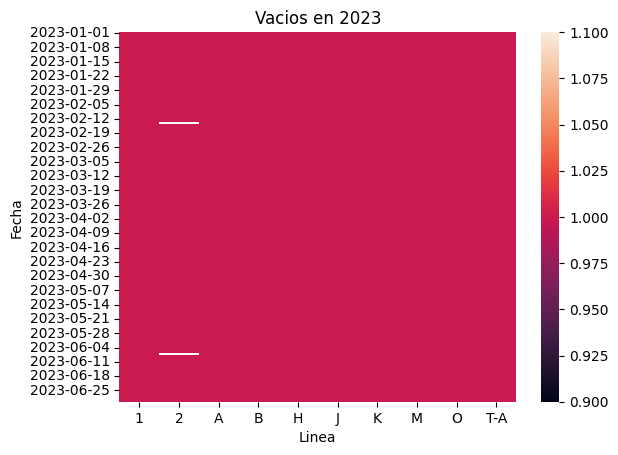

In [16]:
data_chart = all_data.loc[(all_data.Horas=='12') & (all_data.Fecha.dt.year==2023)].copy()
data_chart['Fecha'] = data_chart.Fecha.astype(str)
data_chart['Qty_passangers'] = data_chart.Qty_passangers.apply(lambda x: 1 if x else 0)
data_chart = data_chart.pivot("Fecha", "Linea", "Qty_passangers")

sns.heatmap(data_chart).set(title='Vacios en 2023')

# Rellenando vacios

Para esto se genera una ventana de tiempo con el valor de pasajeros de la linea a la misma hora en los 10 días posteriores y 10 días anteriores

In [14]:
# Rellenando vacios

def custom_window(group):
    # Crea una nueva columna con una lista de valores de 'Qty_passangers' con una ventana de 5 días hacia adelante y hacia atrás
    window_values = []
    for i in range(len(group)):
        start_index = max(0, i - 10)
        end_index = min(len(group), i + 11)
        window_values.append(group['Qty_passangers'].iloc[start_index:end_index].tolist())
    
    group['Qty_passangers_window'] = window_values
    
    return group

# Asegurando el datetime en Fecha
all_data['Fecha'] = pd.to_datetime(all_data['Fecha'])

# Ordenando el dataset
all_data = all_data.sort_values(by=['Linea', 'Horas'])

# Agrupando los datos por 'Linea' y 'Horas'
grouped = all_data.groupby(['Linea', 'Horas'])

# Aplica la función a cada grupo
all_data = grouped.apply(custom_window)

# Mediana
all_data['Media'] = all_data.Qty_passangers_window.apply(lambda lista: statistics.median(lista))

# Promedio
all_data['promedio'] = all_data.Qty_passangers_window.apply(lambda lista: statistics.mean(lista))

all_data['relacion'] = all_data.Media / all_data.promedio

Evaluemos el sentido que tiene lo realizado anteriormente, evaluando la integridad de la ventana escogida. Para esto se plantea la hipotesis que si la relación entre la Media y la Mediana está cercana a 1 es que la ventana es integra (Esto puede contener atipicos. Pero principalmente se está evaluando que tanto lo están desplazando los 0 del dataset presentes en la ventana escogida)

[Text(0.5, 1.0, 'Distribución de la relación entre la Media y la Mediana')]

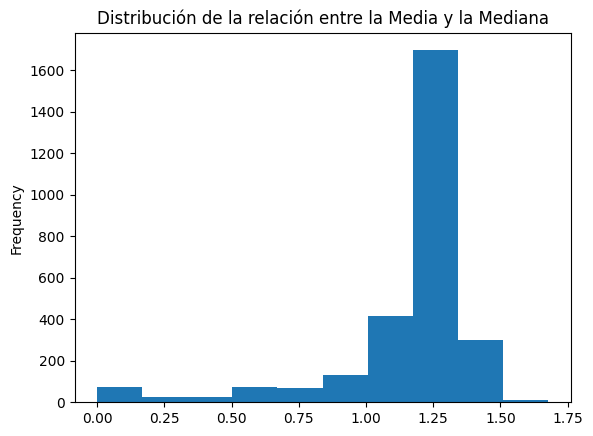

In [15]:
all_data.loc[all_data.Qty_passangers==0, 'relacion'].plot(kind='hist').set(title='Distribución de la relación entre la Media y la Mediana')

In [35]:
all_data

,Fecha,Linea,Horas,Qty_passangers,uploaded,festivos,Qty_passangers_window,Media,promedio,relacion
60,2021-01-01,1,05,614.0,2023-11-13 13:14:18.934912,1,"[614.0, 1291.0, 965.0, 4561.0, 4658.0, 4745.0,...",2832.0,2885.636364,0.981413
216,2021-01-02,1,05,1291.0,2023-11-13 13:14:18.934912,0,"[614.0, 1291.0, 965.0, 4561.0, 4658.0, 4745.0,...",3696.5,3082.500000,1.199189
391,2021-01-03,1,05,965.0,2023-11-13 13:14:18.934912,0,"[614.0, 1291.0, 965.0, 4561.0, 4658.0, 4745.0,...",4561.0,3244.538462,1.405747
577,2021-01-04,1,05,4561.0,2023-11-13 13:14:18.934912,0,"[614.0, 1291.0, 965.0, 4561.0, 4658.0, 4745.0,...",4609.5,3380.285714,1.363642
785,2021-01-05,1,05,4658.0,2023-11-13 13:14:18.934912,0,"[614.0, 1291.0, 965.0, 4561.0, 4658.0, 4745.0,...",4658.0,3501.666667,1.330224
...,...,...,...,...,...,...,...,...,...,...
39081,2023-06-26,T-A,22,1023.0,2023-11-13 13:14:18.934912,0,"[1416.0, 1473.0, 329.0, 237.0, 983.0, 208.0, 1...",1080.0,958.800000,1.126408
39308,2023-06-27,T-A,22,1072.0,2023-11-13 13:14:18.934912,0,"[1473.0, 329.0, 237.0, 983.0, 208.0, 1080.0, 1...",1076.0,926.142857,1.161808
39536,2023-06-28,T-A,22,1138.0,2023-11-13 13:14:18.934912,0,"[329.0, 237.0, 983.0, 208.0, 1080.0, 1380.0, 1...",1072.0,884.076923,1.212564
39764,2023-06-29,T-A,22,1126.0,2023-11-13 13:14:18.934912,0,"[237.0, 983.0, 208.0, 1080.0, 1380.0, 1191.0, ...",1076.0,930.333333,1.156575


In [ ]:
# Graficas de relación en los ceros

import seaborn as sns
import matplotlib.pyplot as plt

for dia in np.arange(20, 28):
    data_grafica = all_data.loc[(all_data.Linea=='M') & (all_data.Fecha==f'2022-08-{dia}')]
    plt.figure()
    sns.lineplot(data=data_grafica, x='Horas', y='Qty_passangers').set(title= f'dia: 2022-08-{dia} dia semana: {data_grafica.dia_semana.unique()}')